# **Install kaggle  and Download Data from Kaggle**

In [ ]:
#  INSTALL & DOWNLOAD
# -------------------------------------------------------------
# (Run only once per session)
!pip install -q kaggle

# Make sure your Kaggle credentials are available:
import os, json, textwrap
os.environ['KAGGLE_USERNAME'] = 'YOUR_USERNAME'
os.environ['KAGGLE_KEY']      = 'YOUR_KEY'

!kaggle datasets download -d subhajournal/phishingemails -p /content
!unzip -o /content/phishingemails.zip -d /content/phishing_emails


Dataset URL: https://www.kaggle.com/datasets/subhajournal/phishingemails
License(s): GNU Lesser General Public License 3.0
  0% 0.00/18.0M [00:00<?, ?B/s]
100% 18.0M/18.0M [00:00<00:00, 610MB/s]
Archive:  /content/phishingemails.zip
  inflating: /content/phishing_emails/Phishing_Email.csv  


In [ ]:
import os, re, time, string, numpy as np, pandas as pd, matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# **Load Data**

In [ ]:

FILE = '/content/phishing_emails/Phishing_Email.csv'
df = pd.read_csv(FILE)


# Display first rows & basic shape
print("Shape:", df.shape)
print(df.head(3), "\n")


Shape: (18650, 3)
   Unnamed: 0                                         Email Text  Email Type
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...  Safe Email
1           1  the other side of * galicismos * * galicismo *...  Safe Email
2           2  re : equistar deal tickets are you still avail...  Safe Email 



# **Data Shape**

In [ ]:

# Drop the extra index column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# ---------- 2. QUICK SANITY CHECK ----------
print(df.shape)


(18650, 2)


In [ ]:
print(df.head(3))

                                          Email Text  Email Type
0  re : 6 . 1100 , disc : uniformitarianism , re ...  Safe Email
1  the other side of * galicismos * * galicismo *...  Safe Email
2  re : equistar deal tickets are you still avail...  Safe Email


# **Prprocssing**

In [ ]:
# ---------- DROP MISSING & SPLIT ----------
df.dropna(subset=['Email Text','Email Type'], inplace=True)

In [ ]:
# ---------- ENHANCED TEXT-CLEANING FUNCTION ----------
import re, nltk, string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# one-time download (comment out after first run)
nltk.download('stopwords')

_stop  = set(stopwords.words('english'))
_stem  = PorterStemmer().stem
_punc  = str.maketrans('', '', string.punctuation)   # faster than regex for punct

def clean_text(txt: str) -> str:
    """Return a normalised, stemmed, stop-word–free version of txt."""
    txt = str(txt).lower()

    #  replace URLs with token
    txt = re.sub(r'https?://\S+|www\.\S+', ' url ', txt)

    #  remove punctuation and numbers
    txt = txt.translate(_punc)               # strip punctuation
    txt = re.sub(r'\d+', ' ', txt)           # strip digits

    #  collapse whitespace
    txt = re.sub(r'\s+', ' ', txt).strip()

    #  token-level processing: stop-word removal & stemming
    tokens = [
        _stem(tok) for tok in txt.split()
        if tok not in _stop and len(tok) > 1          # drop stop-words & single chars
    ]
    return ' '.join(tokens)

# apply to DataFrame
df['text'] = df['Email Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['text']

,text
0,disc uniformitarian sex lang dick hudson obser...
1,side galicismo galicismo spanish term name imp...
2,equistar deal ticket still avail assist robert...
3,hello hot lil horni toy one dream open mind pe...
4,softwar incred low price lower draperi sevente...
...,...
18645,date lone housewif alway want date lone housew...
18646,request submit access request anita dupont enr...
18647,import prc mtg hi dorn john discov recent stil...
18648,press clip letter californian util pleas find ...


In [ ]:

# Encode labels → 0 = safe, 1 = phishing
label_map   = {'Safe Email':0, 'Phishing Email':1}
df['label'] = df['Email Type'].map(label_map)

# **EDA**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18634 entries, 0 to 18649
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  18634 non-null  object
 1   Email Type  18634 non-null  object
 2   text        18634 non-null  object
 3   label       18634 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 727.9+ KB


In [ ]:
df['Email Type'].value_counts()

,count
Email Type,
Safe Email,11322
Phishing Email,7312


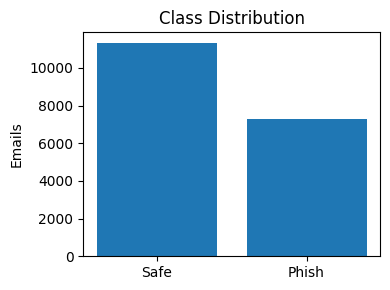

In [ ]:

# ---------- SIMPLE EDA PLOTS ----------
# A. class counts
counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(4,3))
plt.bar(['Safe','Phish'], counts)
plt.title('Class Distribution')
plt.ylabel('Emails')
plt.tight_layout(); plt.show()


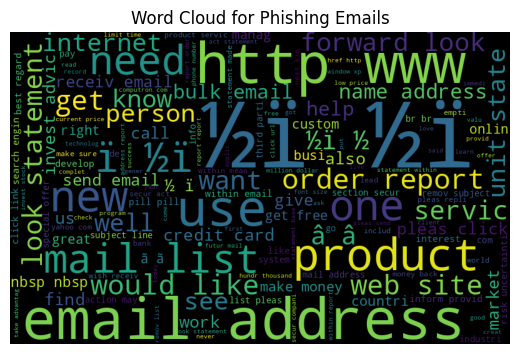

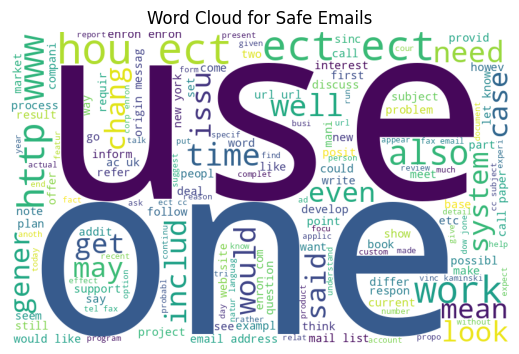

In [ ]:
# generate wordcloud on phising and safe email

import matplotlib.pyplot as plt
!pip install wordcloud
from wordcloud import WordCloud

# Separate text by label
phishing_text = ' '.join(df[df['label'] == 1]['text'])
safe_text = ' '.join(df[df['label'] == 0]['text'])

# Generate WordCloud for Phishing Emails
wordcloud_phishing = WordCloud(width = 800, height = 500,
                background_color ='black',
                stopwords = _stop,
                min_font_size = 10).generate(phishing_text)

# plot the WordCloud image
plt.figure(figsize = (5, 8), facecolor = None)
plt.imshow(wordcloud_phishing)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word Cloud for Phishing Emails")
plt.show()

# Generate WordCloud for Safe Emails
wordcloud_safe = WordCloud(width = 800, height = 500,
                background_color ='white',
                stopwords = _stop,
                min_font_size = 10).generate(safe_text)

# plot the WordCloud image
plt.figure(figsize = (5, 8), facecolor = None)
plt.imshow(wordcloud_safe)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word Cloud for Safe Emails")
plt.show()

# **Data Splitting**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

print(f"train: {len(X_train)}  test: {len(X_test)}")

train: 14907  test: 3727


count    1.863400e+04
mean     2.365955e+02
std      1.046287e+04
min      0.000000e+00
50%      7.400000e+01
90%      3.390000e+02
95%      5.550000e+02
99%      1.316010e+03
99.9%    6.408525e+03
max      1.427477e+06
Name: text, dtype: float64


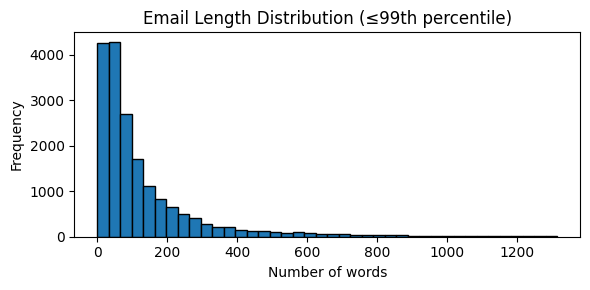

In [ ]:
lengths = df['text'].str.split().apply(len)
print(lengths.describe(percentiles=[.9, .95, .99, .999]))
#  message lengths
p99 = lengths.quantile(0.99)
trimmed = lengths[lengths <= p99]

plt.figure(figsize=(6,3))
plt.hist(trimmed, bins=40, edgecolor='black')
plt.title('Email Length Distribution (≤99th percentile)')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# **Top-20 TF-IDF**

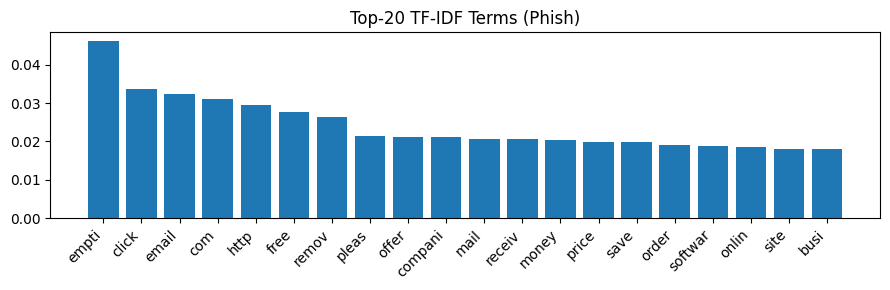

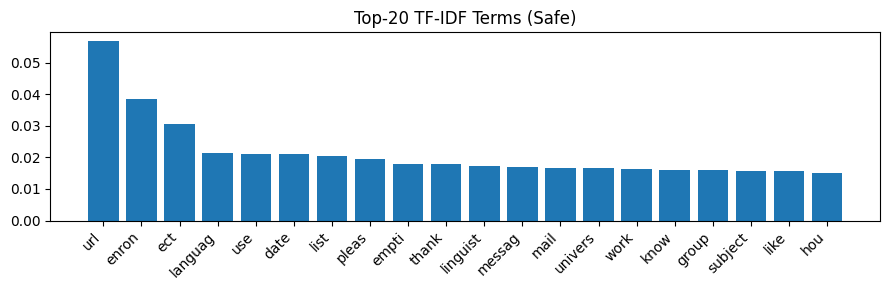

In [ ]:

# Top-20 TF-IDF words for each class
tfidf_all = TfidfVectorizer(stop_words='english', max_features=3000)
X_all     = tfidf_all.fit_transform(df['text'])
terms     = np.array(tfidf_all.get_feature_names_out())
for cls,name in [(1,'Phish'),(0,'Safe')]:
    idx  = np.where(df['label']==cls)[0]
    mean = np.asarray(X_all[idx].mean(axis=0)).ravel()
    top  = mean.argsort()[-20:][::-1]
    plt.figure(figsize=(9,3))
    plt.bar(range(20), mean[top]); plt.xticks(range(20), terms[top], rotation=45, ha='right')
    plt.title(f'Top-20 TF-IDF Terms ({name})'); plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import re, string, seaborn as sns
import warnings
warnings.filterwarnings(
    "ignore",
    message="Clustering metrics expects discrete values",
    module="sklearn.metrics.cluster"
)

# **chi_scores**

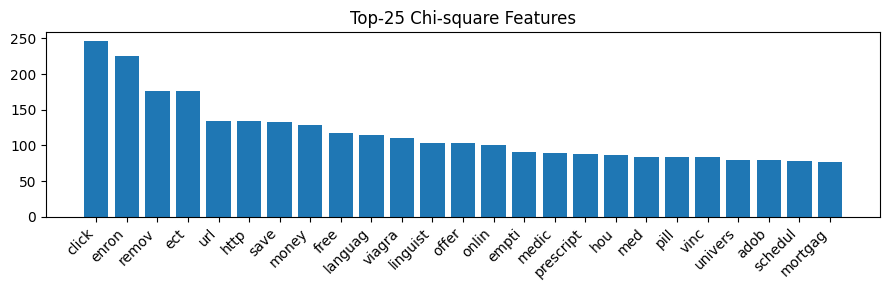

In [ ]:
X_train_vec = tfidf_all.transform(X_train)

# Chi-square
chi_scores, _ = chi2(X_train_vec, y_train)
chi_top = np.argsort(chi_scores)[-25:][::-1]
plt.figure(figsize=(9,3))
plt.bar(range(25), chi_scores[chi_top])
plt.xticks(range(25), terms[chi_top], rotation=45, ha='right')
plt.title('Top-25 Chi-square Features'); plt.tight_layout()
plt.show()

# **Mutual Information**

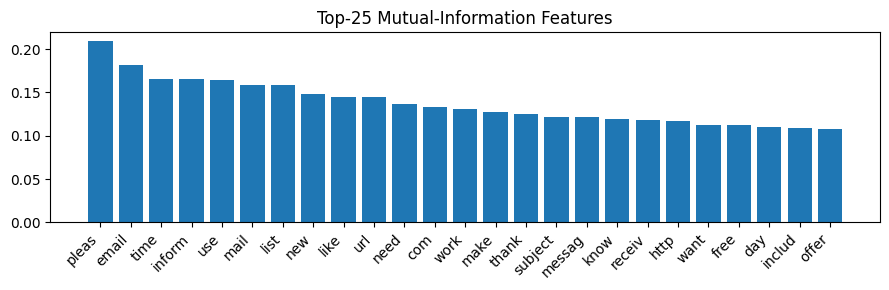

In [ ]:

# Mutual Information
mi_scores = mutual_info_classif(X_train_vec, y_train, discrete_features=True)
mi_top    = np.argsort(mi_scores)[-25:][::-1]
plt.figure(figsize=(9,3))
plt.bar(range(25), mi_scores[mi_top])
plt.xticks(range(25), terms[mi_top], rotation=45, ha='right')
plt.title('Top-25 Mutual-Information Features'); plt.tight_layout()


# **Model Development**

## **FEATURE SELECTION (chi-square & mutual information)**

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2),
                        stop_words='english',
                        max_features=3_000)

models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "LinSVC": LinearSVC(class_weight='balanced'),

}

k = 1_000  # number of top features to keep



==========  Chi-square  ==========


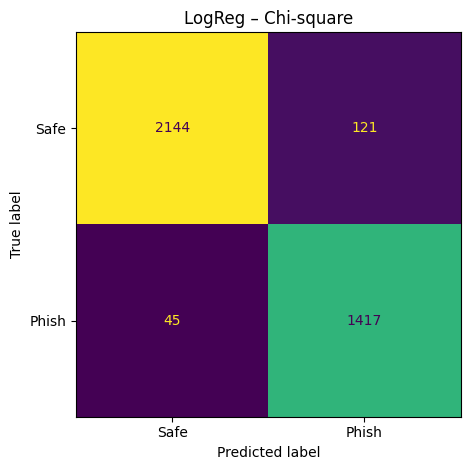

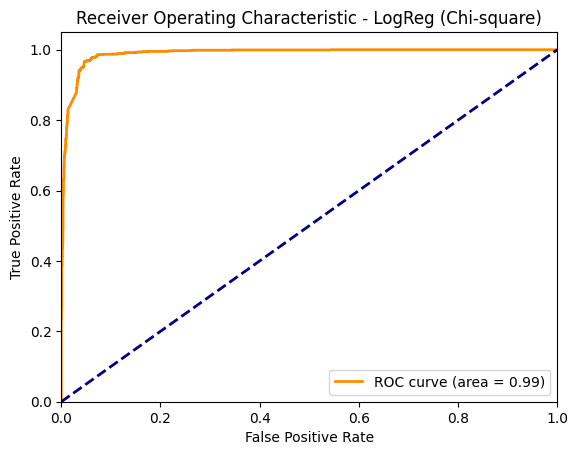

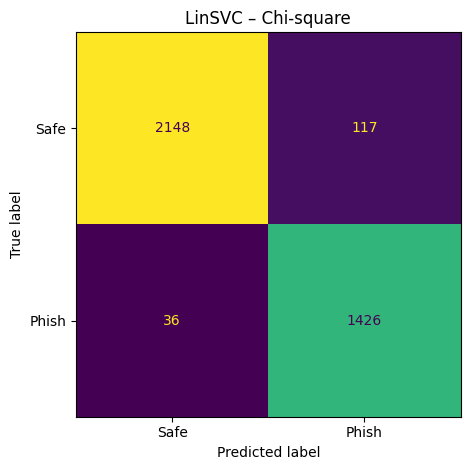

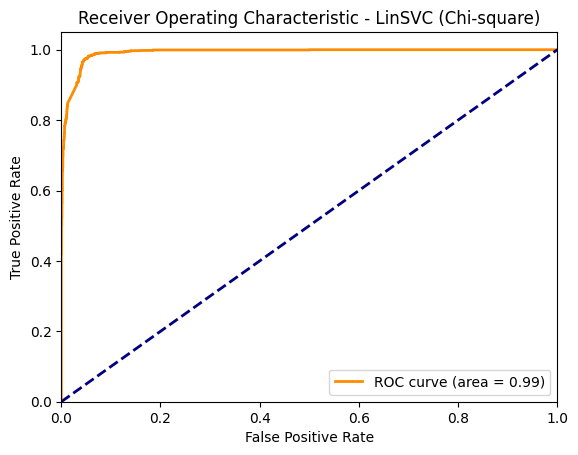

,Accuracy,Precision,Recall,F1,Train_s,Test_s
Model,,,,,,
LogReg,0.9555,0.9213,0.9692,0.9447,20.4694,1.4628
LinSVC,0.9589,0.9242,0.9754,0.9491,13.7278,0.9470



==========  Mutual-Information  ==========


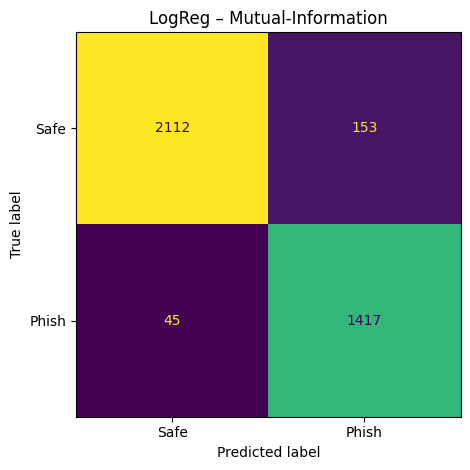

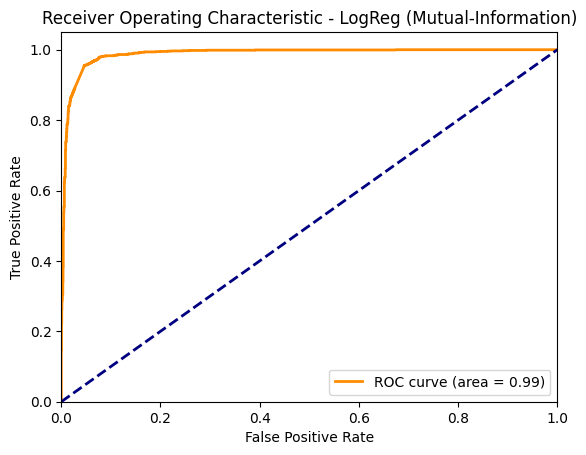

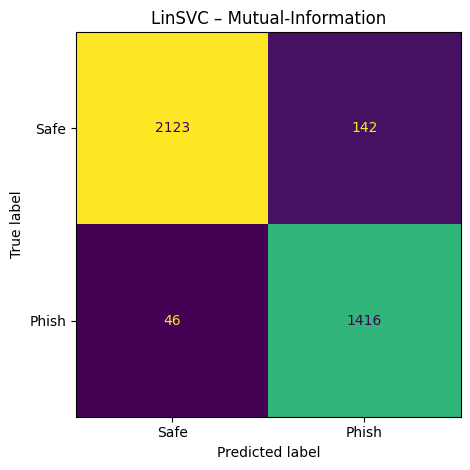

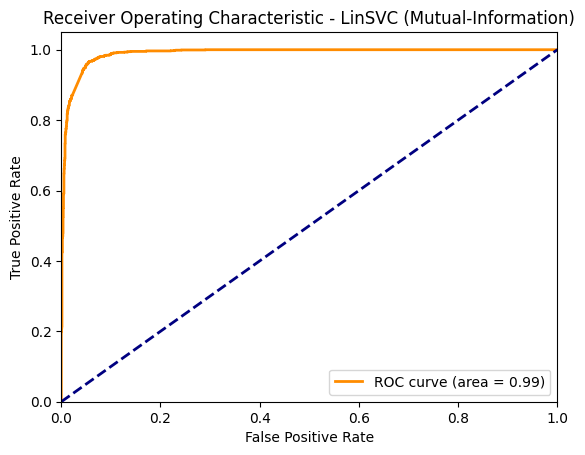

,Accuracy,Precision,Recall,F1,Train_s,Test_s
Model,,,,,,
LogReg,0.9469,0.9025,0.9692,0.9347,24.7600,0.9655
LinSVC,0.9496,0.9089,0.9685,0.9377,26.2785,0.8915


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, precision_recall_fscore_support
import re, string, seaborn as sns
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings(
    "ignore",
    message="Clustering metrics expects discrete values",
    module="sklearn.metrics.cluster"
)


def evaluate_selector(selector_name, score_func):
    print(f"\n==========  {selector_name}  ==========")
    sel = SelectKBest(score_func=score_func, k=k)
    rows = []

    for name, clf in models.items():
        pipe = Pipeline([("tfidf", tfidf),
                         ("sel",   sel),
                         ("clf",   clf)])

        # --- train ---
        t0 = time.perf_counter()
        pipe.fit(X_train, y_train)
        train_s = time.perf_counter() - t0

        # --- predict ---
        t1 = time.perf_counter()
        y_pred = pipe.predict(X_test)
        test_s = time.perf_counter() - t1

        # --- metrics ---
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='binary', pos_label=1)
        acc = accuracy_score(y_test, y_pred)
        rows.append(dict(Model=name, Accuracy=acc,
                         Precision=prec, Recall=rec, F1=f1,
                         Train_s=train_s, Test_s=test_s))

        # --- confusion matrix ---
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, display_labels=['Safe','Phish'],
            cmap='viridis', values_format='d', colorbar=False)
        plt.title(f"{name} – {selector_name}")
        plt.tight_layout(); plt.show()

        # --- ROC Curve ---
        if hasattr(pipe, 'predict_proba'):
            y_pred_proba = pipe.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic - {name} ({selector_name})')
            plt.legend(loc="lower right")
            plt.show()
        elif hasattr(pipe, 'decision_function'):
             y_pred_score = pipe.decision_function(X_test)
             fpr, tpr, _ = roc_curve(y_test, y_pred_score)
             roc_auc = auc(fpr, tpr)

             plt.figure()
             plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
             plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
             plt.xlim([0.0, 1.0])
             plt.ylim([0.0, 1.05])
             plt.xlabel('False Positive Rate')
             plt.ylabel('True Positive Rate')
             plt.title(f'Receiver Operating Characteristic - {name} ({selector_name})')
             plt.legend(loc="lower right")
             plt.show()


    display(pd.DataFrame(rows).set_index('Model').round(4))

# ==============================================================
#   RUN BOTH SELECTORS
# ==============================================================
evaluate_selector("Chi-square", chi2)
evaluate_selector("Mutual-Information", mutual_info_classif)

# **Model Development with Hyper Tuning**

## **Model with TFIDF**

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2),
                        stop_words='english',
                        max_features=3_000)

models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "LinSVC": LinearSVC(class_weight='balanced'),

}

k = 1_000  # number of top features to keep



==========  TF-IDF Baseline (No Feature Selection)  ==========


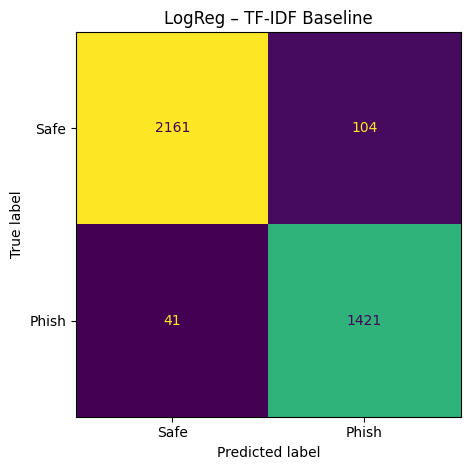

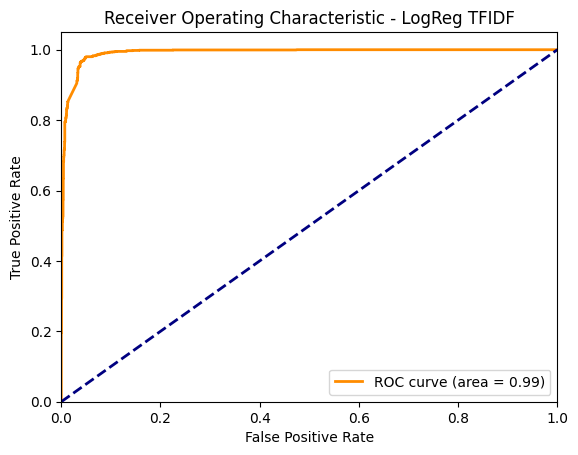

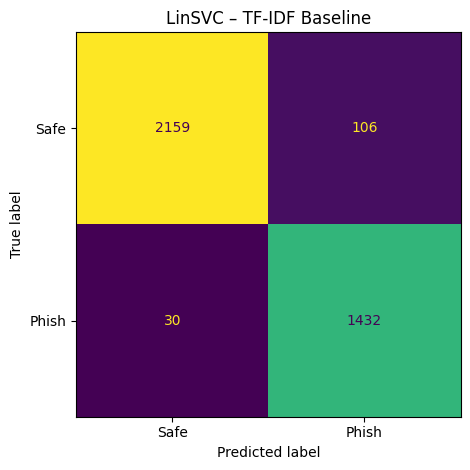

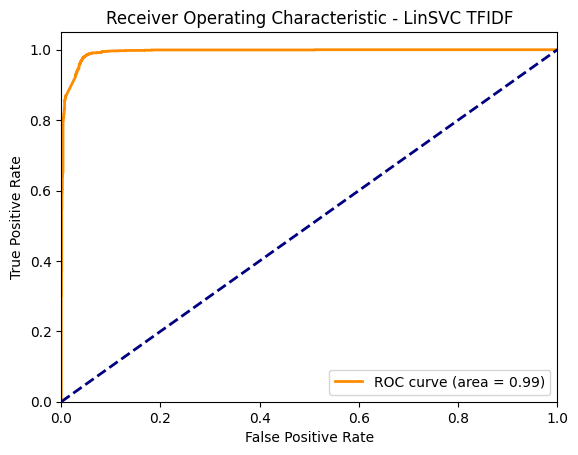

,Accuracy,Precision,Recall,F1,Train_s,Test_s
Model,,,,,,
LogReg,0.9611,0.9318,0.9720,0.9515,14.9835,1.5678
LinSVC,0.9635,0.9311,0.9795,0.9547,14.2286,0.9948


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import time

# Set number of top features to keep
k = 1000


# Define baseline evaluation (no feature selector)
def evaluate_tfidf_baseline():
    print(f"\n==========  TF-IDF Baseline (No Feature Selection)  ==========")
    rows = []

    for name, clf in models.items():
        pipe = Pipeline([
            ("tfidf", tfidf),
            ("clf", clf)
        ])

        # Train
        t0 = time.perf_counter()
        pipe.fit(X_train, y_train)
        train_s = time.perf_counter() - t0

        # Predict
        t1 = time.perf_counter()
        y_pred = pipe.predict(X_test)
        test_s = time.perf_counter() - t1

        # Metrics
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
        acc = accuracy_score(y_test, y_pred)
        rows.append(dict(Model=name, Accuracy=acc, Precision=prec, Recall=rec, F1=f1,
                         Train_s=train_s, Test_s=test_s))

        # Confusion matrix
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, display_labels=['Safe','Phish'],
            cmap='viridis', values_format='d', colorbar=False)
        plt.title(f"{name} – TF-IDF Baseline")
        plt.tight_layout(); plt.show()

        # --- ROC Curve ---
        if hasattr(pipe, 'predict_proba'):
            y_pred_proba = pipe.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic - {name} TFIDF')
            plt.legend(loc="lower right")
            plt.show()
        elif hasattr(pipe, 'decision_function'):
             y_pred_score = pipe.decision_function(X_test)
             fpr, tpr, _ = roc_curve(y_test, y_pred_score)
             roc_auc = auc(fpr, tpr)

             plt.figure()
             plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
             plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
             plt.xlim([0.0, 1.0])
             plt.ylim([0.0, 1.05])
             plt.xlabel('False Positive Rate')
             plt.ylabel('True Positive Rate')
             plt.title(f'Receiver Operating Characteristic - {name} TFIDF')
             plt.legend(loc="lower right")
             plt.show()


    display(pd.DataFrame(rows).set_index('Model').round(4))

# ==============================================================
#   RUN ALL EVALUATIONS
# ==============================================================
evaluate_tfidf_baseline()


# **Deep Learning Model**

## **Text Preprocessing (Tokenize + Pad)**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import time

# -----------------------------------------------
# 1. Text Preprocessing (Tokenize + Pad)
# -----------------------------------------------
vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


## **Define Model Architectures**

In [ ]:


def build_gru_model():
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_len),
        GRU(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model



## **Function to Train and Evaluate a Model**

In [ ]:
from sklearn.metrics import roc_curve, auc

def train_and_evaluate(model, model_name):
    print(f"\n========== Training: {model_name} ==========")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    t0 = time.perf_counter()
    history = model.fit(X_train_pad, y_train,
                        validation_split=0.2,
                        epochs=10,
                        batch_size=32,
                        verbose=2)
    train_time = time.perf_counter() - t0

    print(f"\n========== Evaluation: {model_name} ==========")
    t1 = time.perf_counter()
    y_pred_probs = model.predict(X_test_pad)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    test_time = time.perf_counter() - t1

    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Safe', 'Phish']))

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=['Safe', 'Phish'],
        cmap='viridis', values_format='d', colorbar=False)
    plt.title(f"{model_name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # ==== ROC Curve ====
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} – ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ==== Training History ====
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} – Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Train Time: {train_time:.2f}s | Test Time: {test_time:.2f}s")


## **Train All Models**


========== Training: GRU ==========
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


373/373 - 38s - 103ms/step - accuracy: 0.7659 - loss: 0.4375 - val_accuracy: 0.9403 - val_loss: 0.1666
Epoch 2/10
373/373 - 33s - 88ms/step - accuracy: 0.9632 - loss: 0.1006 - val_accuracy: 0.9624 - val_loss: 0.1033
Epoch 3/10
373/373 - 42s - 112ms/step - accuracy: 0.9791 - loss: 0.0523 - val_accuracy: 0.9655 - val_loss: 0.1068
Epoch 4/10
373/373 - 34s - 92ms/step - accuracy: 0.9831 - loss: 0.0358 - val_accuracy: 0.9628 - val_loss: 0.1103
Epoch 5/10
373/373 - 34s - 91ms/step - accuracy: 0.9861 - loss: 0.0281 - val_accuracy: 0.9531 - val_loss: 0.1223
Epoch 6/10
373/373 - 34s - 91ms/step - accuracy: 0.9839 - loss: 0.0295 - val_accuracy: 0.9624 - val_loss: 0.1358
Epoch 7/10
373/373 - 41s - 109ms/step - accuracy: 0.9871 - loss: 0.0240 - val_accuracy: 0.9641 - val_loss: 0.1364
Epoch 8/10
373/373 - 42s - 111ms/step - accuracy: 0.9879 - loss: 0.0228 - val_accuracy: 0.9561 - val_loss: 0.1835
Epoch 9/10
373/373 - 33s - 88ms/step - accuracy: 0.9873 - loss: 0.0245 - val_accuracy: 0.9611 - val_los

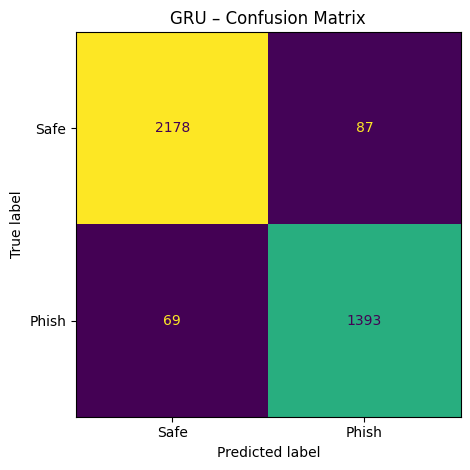

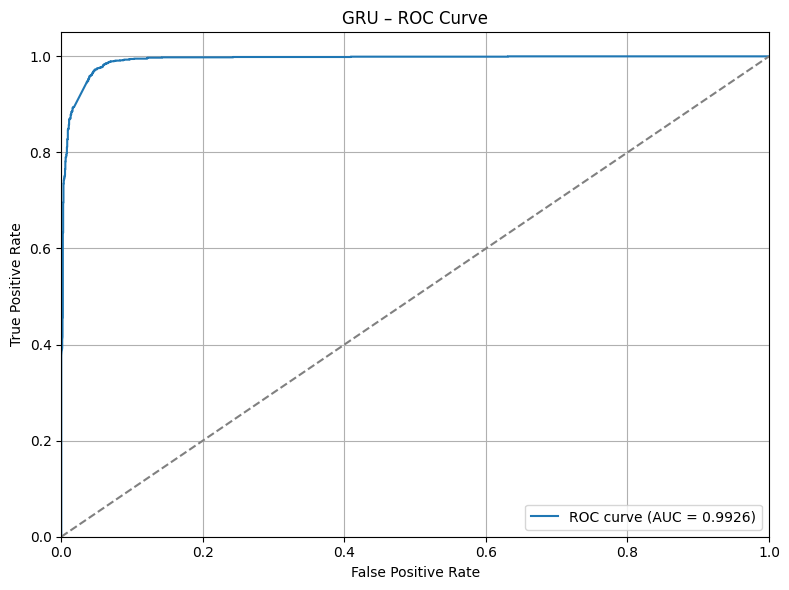

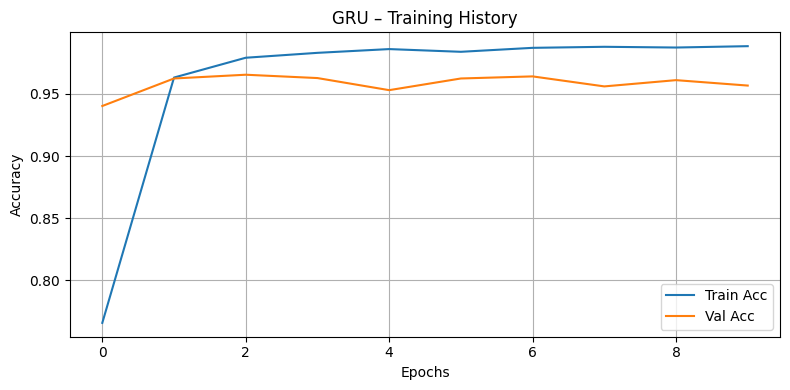

Train Time: 364.15s | Test Time: 2.97s


In [ ]:


models_to_run = {

    "GRU": build_gru_model,

}

for model_name, build_fn in models_to_run.items():
    model = build_fn()
    train_and_evaluate(model, model_name)
